# Simulating null distributions for outlier scans

In [1]:
import msprime, tskit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

We are interested in understanding the divergence between two species. We will focus (perhaps wrongly...) on the most popular summary of differentiation between: $F_{st}$. Let's assume we have been analysing $F_{st}$ in windows of 32kb for a sample of 5 diploid individuals per species and have observed some tantalizing outliers in the $F_{st}$ scan:

(0, 0.6)

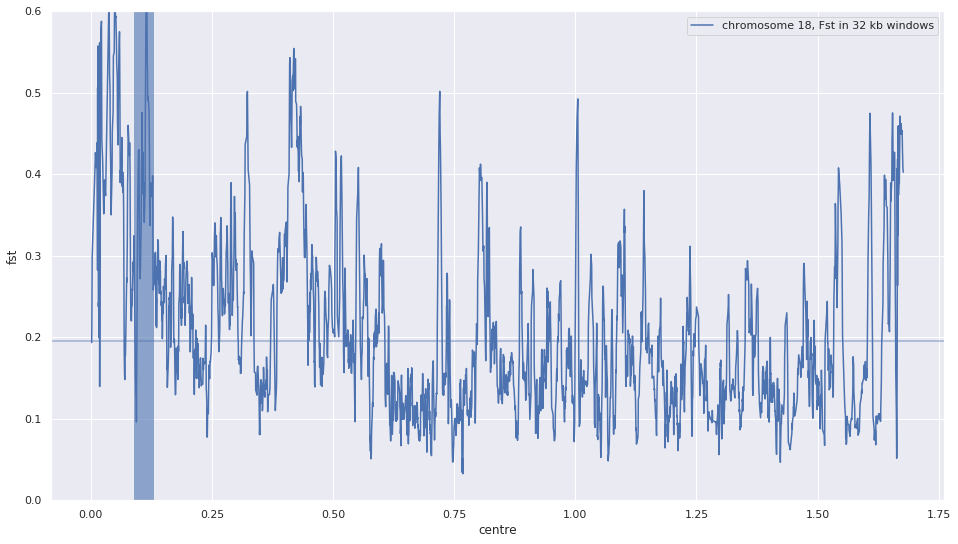

In [46]:
#KL add colours here 
hmel18 = pd.read_csv('chrom18.csv')
hmel18.head()
genePos=(1058778+1159581)/2

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(hmel18['centre']/10e6, hmel18['fst'],label='chromosome 18, Fst in 32 kb windows')
#horizontal line mean Fst with heterogeneity
plt.axvline(x=genePos/10e6, linewidth=20, alpha=0.6)
plt.axhline(y=hmel18['fst'].mean(), alpha=0.5)
plt.legend()
ax.set_ylim((0,0.6))

$F_{st}$ has a wide distribution:

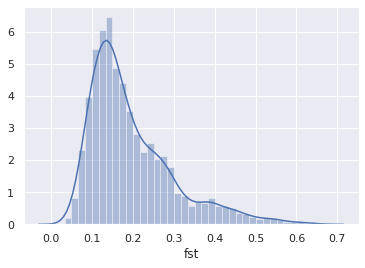

In [39]:
sns.distplot( hmel18['fst'], label='Fst in 32kb wins, n=20', norm_hist=True)

### A super simple toy example

We want to get a feel for the distribution of windowise $F_{st}$ under a really simple null and a realistic recombination rate of 1.84 10^-8 (average $r$ per base from Davey et al. 2017). Let's define a history of strict divergence (i.e. no gene flow) at time $T=0.5$ ($\times 2N_e$ generations) between two populations of equal size ($N_e=500000$) in msprime:

In [283]:
#number of samples (2Xof diploid individuals) per deme:
sample_size = 10

#Rates for migration, recombination and mutation are unscaled and per generation:
seqLength = 32e3 
recr = 1.84675e-8
Ne = 5e5
splitT = 5e5

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne),
    ]
#demographic events are specified in the order they occur backwards in time:
# MassMigration specifies the split between population 0 and 1: 
# backwards in time all lineages from the smaller population (1) are derived from pop (0)
# at time T 
demographic_events = [
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    ]

We want to simulate a largish - say 200 - number of replicate 32kb windows under this history in msprime. Simulations are pseudorandom, i.e. we start by generating a vector of random seeds:

In [266]:
#Jerome, did we we use the seed correctly?  
num_reps = 10
seed = np.random.randint(1, 2**32 - 1, 1)
#seed = np.random.randint(1, 2**32 - 1, 1)
replicates = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        random_seed=seed)

Note that we have not specified any mutation rate, the code-chunk above is a generator for simulating tree sequences only! However, mutations are a nuisance, we can compute any summary statistic that can be defined in terms of branch lenghts directly from the treesequences. We will use the following $F_{st}$ definition:

$F_{st}= \frac{T_b-T_w}{T_b+T_w}$

where $T_w$ and $T_b$ are the average pairwise coalescence times for a pair of lineages sampled within and between species respectively. Therefore, an estimator of $F_{st}$ is:

$\hat{F_{st}}= \frac{d_{xy}-\pi}{d_{xy}+\pi}$

Note that the above follows from the general definition of $F_{st}$ in terms of expected pairwise coalescence times:

$F_{st}= \frac{T_t-T_w}{T_{t}}$

Where $T_t$ is the average for a pairwise sample taken at random. For the case of two pops/species we assume that we are equally likely to sample from within and between species, so:

$T_t=(T_b + T_w)/2$

We can use the tskit.BranchLengthStatCalculator(ts) to calculate any summary statistic that can be defined in terms of branch lengths in the ancestral recombination graph (this ignores the mutational variance in $F_{st}$, which however is very small given the windowsize). A function for computing $F_{st}$ is built in:

#KL: Insert pict of 1st 3 trees

Simulating 200 replicates takes about 3 minutes: 
#KL Update with tskit version.

In [246]:
def Fst(div_entry):
    A = np.mean((div_entry.diagonal()))
    B = div_entry[1,0]
    return (B-A)/(A+B)

def calculate_Fst(ts, samplesets, function=Fst):
    winlen = [0,ts.sequence_length]
    BranchStat = tskit.BranchLengthStatCalculator(ts)
    div_matrix = BranchStat.divergence_matrix(samplesets,winlen)
    Fst_result = list(map(function, div_matrix))
    return Fst_result

We define an empty numpy array and insert $F_{st}$ estimates for each replicate: 

In [247]:
fstSims = np.zeros(num_reps)
for index, ts in enumerate(replicates):
    p1 = list(ts.get_samples(0))
    p2 = list(ts.get_samples(1))
    fstSims[index] = calculate_Fst(ts,samplesets=[p1,p2])[0]

The mean $F_{st}$ is:

In [162]:
fstSims.mean()

0.2068862870012268

The expectation for $F_{st}$ under the this model can be found using the coalescence definition above and $E[T_w]=1$ and $E[T_b]=T+1$. Check how well this matches the mean across simulations...

In [136]:
# KL: Remove..
(0.5)/(0.5+2)

0.2

In [130]:
# KL: Remove..
def expected_Fst(splitT, Ne):
    within = 2*Ne
    between = splitT + 2*Ne
    return (between-within)/(between+within)

The distribution of $F_{st}$ across windows is wide (and no analytic results exist).

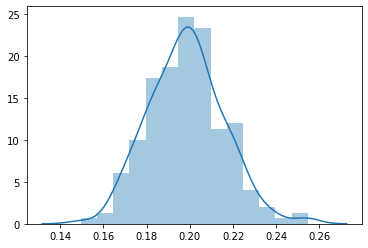

In [125]:
sns.distplot(fstSims, label='Fst in 32kb wins, n=20', norm_hist=True)

Note that the tree sequence for each window contains about 5,000 marginal trees, i.e. recombination breakpoints:

In [267]:
#np.zeros(num_reps)
#mutlist=[[tree.num_mutations for tree in ts.trees()] for ts in replicates]
lenlist=[[tree.length for tree in ts.trees()] for ts in replicates]
print([len(l) for l in lenlist])
np.mean(lenlist[0])

[4959, 4662, 4887, 5148, 5000, 4789, 5254, 4997, 4595, 4643]


6.452913893930228

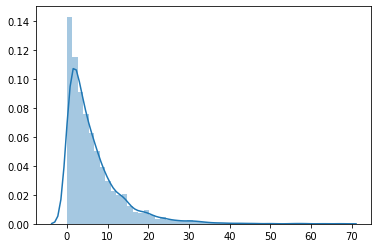

In [264]:
sns.distplot(lenlist[1], norm_hist=True)

## Divergence with constant migration

Let's (for now) assume that we have very concrete information on the background demography and have estimated parameters under a simple null model of divergence with gene flow. Our cartoon history estimated from genome-wide data (we will give an example of how to do this using GimBL tomorrow) has four parameters: 

- a population split time $T$ (in generations) between pop0 and pop1.
- a constant rate of unidirectional gene flow $m$ (per generation from pop1 to pop0).
- two effective population sizes (we assume that the common ancestral pop has the same effective size as pop0). 

We will assume values estimated for two spevcies of Heliconius for the demography, i.e. $N_e$ on the order of $10^6$ and divergence $T \approx 5 \times 10^6$. Assuming the same window size (32kb) and $r$ (1.84675e-8) as before, use msprime to obtain an upper critical value of $F_{st}$. 

How many windows in the Hmel Hcyd data show a significant $F_{st}$ given this demographic history? 

Is this more or less than expected under the demography?

The  code chunk below sets up msprime simulation under the msprime history: 

In [293]:
#number of samples (2Xof diploid individuals) per deme:
nsamp = 10
pop = list(range(0,nsamp*2))
p1, p2 = pop[:nsamp], pop[nsamp:]

#Rates for migration, recombination and mutation are unscaled and per generation:
mig = 3.8866e-7
seqLength = 32e3 
recr = 1.84675e-8
Ne0 = 2.3241e6
Ne1 = 9.8922e5 
splitT = 4.8580e6

# demographic events are specified in the order they occur backwards in time:
# The MassMigration specifies the split between population 0 and 1: 
# backwards in time all lineages from the smaller population (1) are derived from pop (0)
# at time T 
# migration matrix specifies a matrix of pairwise migration rates (backwards in time).
migration_matrix = [[0,0], [mig,0]]

In [294]:
#KL: Remove 
num_reps = 100
seed = np.random.randint(1, 2**32 - 1, 1)
#seed = np.random.randint(1, 2**32 - 1, 1)
replicates = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],[mig,0]],
        random_seed=seed)

fstSims = np.zeros(num_reps)
for index, ts in enumerate(replicates):
    fstSims[index] = calculate_Fst(ts,samplesets=[p1,p2])[0]

We estimate $F_{st}$ for each replicate using the tskit function Fst() and store the results in a numpy array:

In [291]:
#KL: Checkpoint 1: provide the simulated F_st as a csv
basic_short = pd.read_csv('basic_short_all.csv')
basic_short.drop(basic_short.columns[[0, 1]], axis=1, inplace=True)
current_winner_short = pd.read_csv('current_winner_short_all.csv')
current_winner_short.drop(current_winner_short.columns[[0, 1]], axis=1, inplace=True)

(0, 0.4)

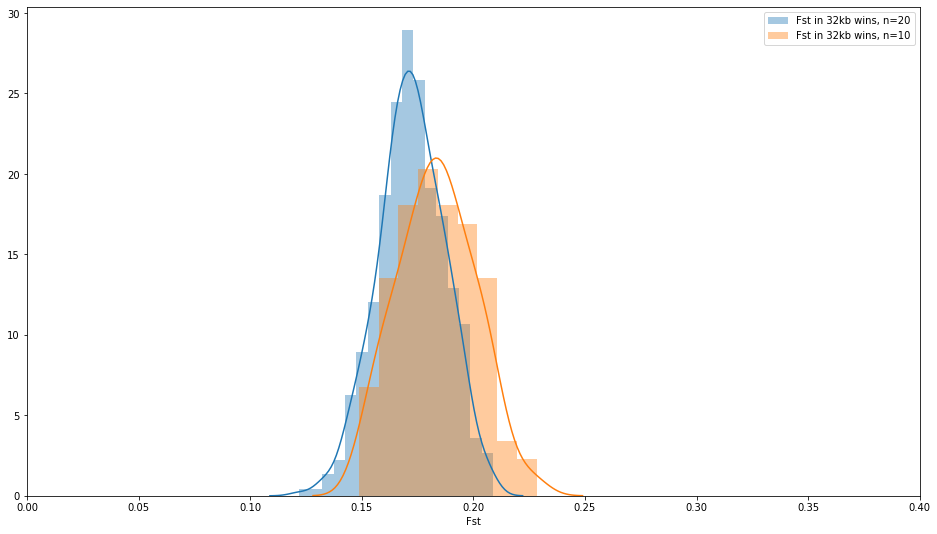

In [296]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(current_winner_short['Fst'], label='Fst in 32kb wins, n=20', norm_hist=True)
sns.distplot(fstSims , label='Fst in 32kb wins, n=10')
plt.legend()
ax.set_xlim((0, 0.4))

We can use this to define a critical values of $F_{st}$:

In [297]:
fstSims.mean(), np.quantile(fstSims,0.95), current_winner_short['Fst'].quantile(0.99)

(0.18353527082303286, 0.21026626223026795, 0.20487587223560247)

or run all this in a script that can be run on multiple cores
change parametes within sim_chuncks.py as desired

In [ ]:
recomb = abs(np.random.normal(loc=1.846, scale=0.1, size=300))/1e8
replicates = msprime.simulate(
        num_replicates = 1,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],
                            [mig,0]],
        mutation_rate = mu)

In [ ]:
#sliding window plot of current winner here

## Divergence with secondary contact

How different is the distribution of $F_{st}$ if we assume that divergence happened in allopatry and has been partially eroded by secondary contact? We assume the same split time $T_{s}$ and $N_e$ as before and a sudden admixture event which transfers a proportion of $f=0.389$ from pop0 to pop1 at time $T_{ad}$. This is specified as another MassMigration event.

In [90]:
T = 4.8580e6
#time of secondary admixture
adT = 5.0772e4 
#proportion of lineages in source migrating into destination that split at time T:
proportionf =0.389 

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne0),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne1),
    ]
    
#demographic events: specify in the order they occur backwards in time.
demographic_events = [
    msprime.MassMigration(time=adT, source=1, destination=0, proportion=proportionf),
    msprime.PopulationParametersChange(time=T, initial_size=Ne0, population_id=0),
    msprime.MassMigration(time=T, source=1, destination=0, proportion=1.0)
    ]

replicatesAD = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events)

In [91]:
fstSimsAD = np.zeros(num_reps)
for index, ts in enumerate(replicatesAD):
    p1 = list(ts.get_samples(0))
    p2 = list(ts.get_samples(1))
    fstSimsAD[index]= calculate_Fst(ts,samplesets=[p1,p2])[0]

In [ ]:
add mean 

(0, 0.4)

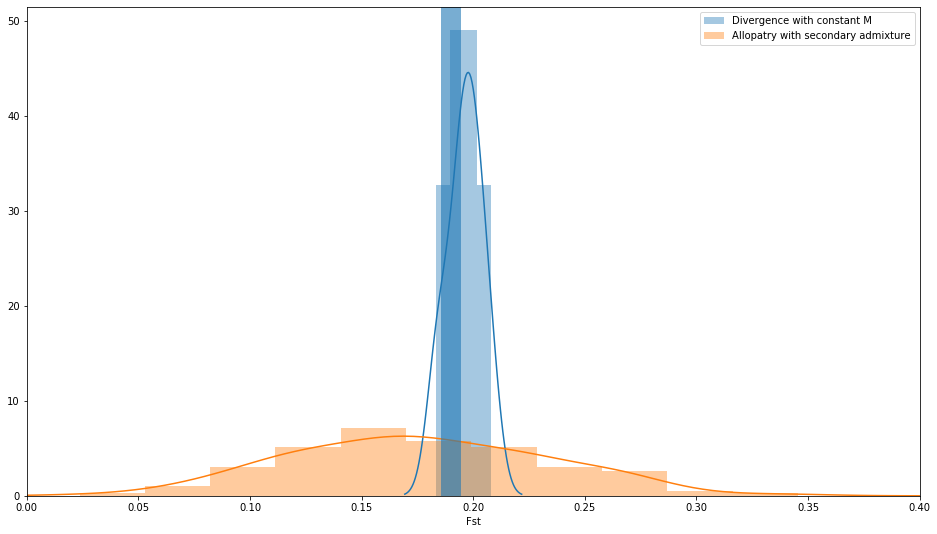

In [276]:
fig, ax = plt.subplots(figsize=(16,9))
fstIM = pd.Series(fstSims, name="Fst")
fstAD = pd.Series(fstSimsAD, name="Fst")
sns.distplot(fstIM,   label='Divergence with constant M')
sns.distplot(fstAD, label='Allopatry with secondary admixture')
plt.axvline(x=0.19, linewidth=20, alpha=0.6)
plt.legend()
ax.set_xlim((0, 0.4))

The mean Fst is very similar for both models, the distribution is much broader under a model of recent admixture:

In [97]:
fstSims.mean(),fstSimsAD.mean()b

(0.18188027232511061, 0.17625734232333878)

What increases the width of the Fst distr? LD due to admixture. Check tree span distribution. How do we get two humps under the admixture model?

## Recombination rate heterogeneity

heli_32kb_Davey2017_rec is a dataframe with recombination rate estimates (cM/Mb) in 32kb windows estimated for Heliconius (Davey et al. 2017 generated three recombination maps for Hmel, Hcyd and the F1, the last column is the mean of these maps).

In [280]:
hapmap = pd.read_csv('heli_32kb_Davey2017_rec.csv', delimiter='\t')
hapmap.head()
#hapmap[hapmap['Chrom']==18]

,chrom,start,end,hmel,hcyd,f1,mean
0,1,66980,122860,1.6355,3.3415,1.5672,2.1814
1,1,122860,168185,1.6336,3.3067,1.7697,2.2367
2,1,168185,208610,1.6328,3.2851,1.9392,2.2857
3,1,208611,243766,1.6326,3.2541,2.0870,2.3246
4,1,243766,279430,1.6329,3.2302,2.2243,2.3624


Note that 32kb is the total length of sequence in a window after filtering (in this case only intergenic data). So windows have a span that is substantially longer than 32 kb.

- Note that using the postfiltering length rather than the span of windows is conservative: we are assuming a shorter map distance

- To make this more realistic one could bin windows by their span measured on the map.


median = 70.672kb


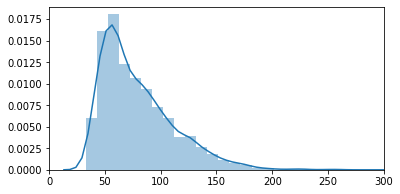

In [281]:
winspan=(hapmap['end']-hapmap['start'])/1000
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(winspan, label='window span')
ax.set_xlim((0, 300))
print("median = "+ str(winspan.median())+"kb")

The distribution of recombination rates across windows is wide:
#telomere effect low rec?

2.014522756706753


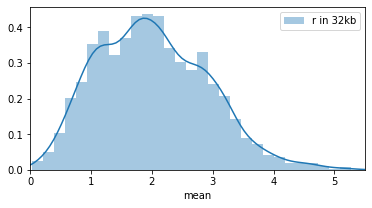

In [145]:
print(hapmap['mean'].mean()/2)
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(hapmap['mean']/2, label='r in 32kb')
ax.set_xlim((0, 5.5))
plt.legend()

We can draw a random sample from the empirical $r$ values and repeat the msprime simulation (200 replicates) under the IM model:

In [147]:
#simulate replicates with different recombination rates cfr. windows.
recomb = np.random.choice(hapmap['mean']/2,size=num_reps)

Note that $r$ is in cM/Mb: to convert to recombination per base and generation, we divide by $10^{-8}$:

In [148]:
#KL: Remove
replicates_RecHet = [msprime.simulate(
        length = seqLength, 
        recombination_rate = rate/10e8,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix =  migration_matrix,
        mutation_rate = mu) for rate in recomb]

In [150]:
fstSims_RecHet = np.zeros(num_reps)
pop = list(range(0,nsamp*2))
p1, p2 = pop[:nsamp], pop[nsamp:]

for index, ts in enumerate(replicates_RecHet):
    fstSims_RecHet[index] = calculate_Fst(ts,samplesets=[p1,p2])[0]

$F_{st}$ has a much wider distribution if we include heterogeneity in $r$. The distribution of windowise $F_{st}$ conditioned on the above divergence and gene flow history for Heliconus melpomene and H. cydno and the Heliconius recombination map for the first 8Mb of chromosome 18 is:

(0, 0.5)

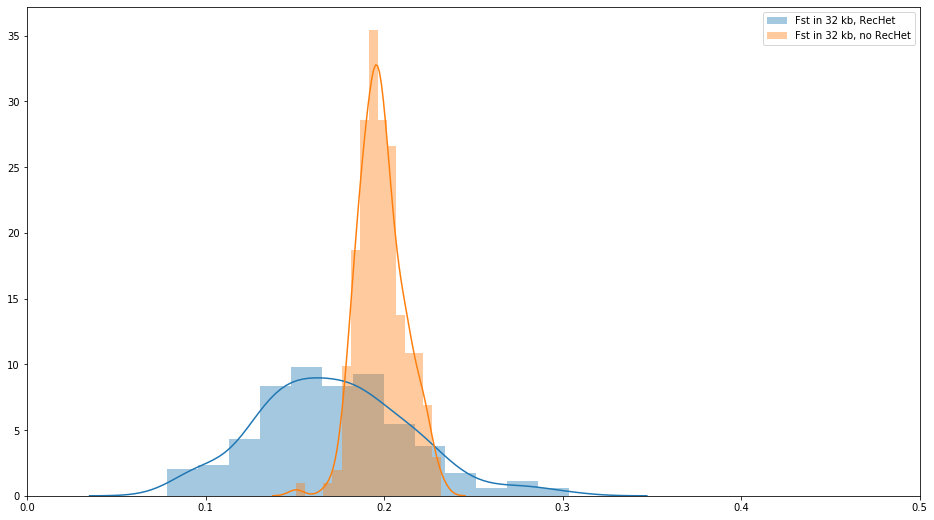

In [151]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(fstSims_RecHet, label='Fst in 32 kb, RecHet')
sns.distplot(fstSims, label='Fst in 32 kb, no RecHet')
plt.legend()
ax.set_xlim((0, 0.5))

# Conditioning simulations on the recombination map

Above we have drawn $r$ from but simulated 32 windows as independent. Ideally we would want to condition any outlier scan (critical values for $F_{st}$ on the $r$ in each window), or even better, condition on a recombination map:

In [7]:
hapmap[hapmap['chrom']==18]

NameError: name 'hapmap' is not defined

In [29]:
dRecHet = pd.read_csv('10Mb_sequence_data/simlarge_hapmap_win.csv')
dNoRecHet = pd.read_csv('10Mb_sequence_data/win_largeFst.csv')

(0, 0.6)

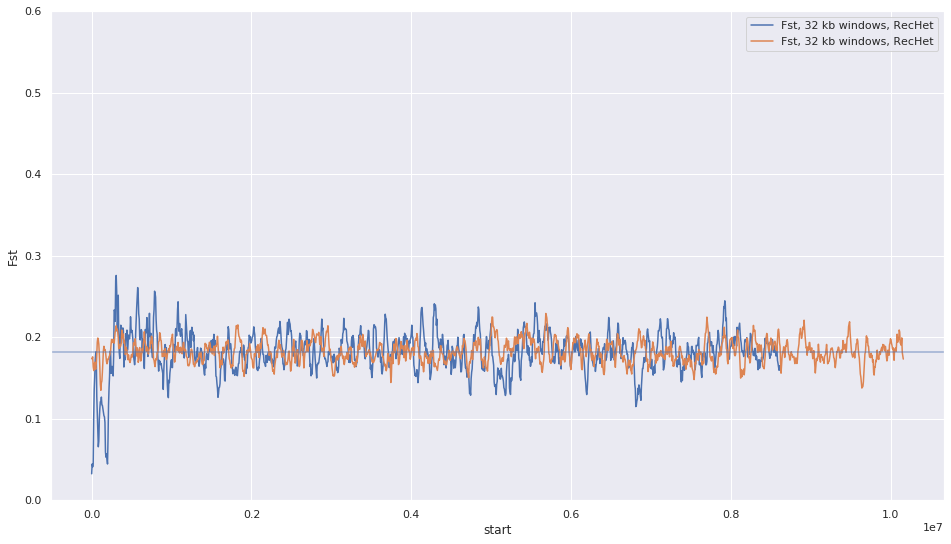

In [31]:
#and sliding wins 
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(dRecHet['start'], dRecHet['Fst'],label='Fst, 32 kb windows, RecHet')
sns.lineplot(dNoRecHet['start'],dNoRecHet['Fst'],label='Fst, 32 kb windows, RecHet')
#horizontal line mean Fst with heterogeneity
plt.axhline(y=dNoRecHet['Fst'].mean(), alpha=0.5)
plt.legend()
ax.set_ylim((0,0.6))

In [ ]:
#and sliding wins 